In [1]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from torch.amp import autocast, GradScaler  #  Updated for latest PyTorch version
import torch.optim as optim
from torchvision import models
from torchmetrics import StructuralSimilarityIndexMeasure
from tqdm import tqdm
import skimage.metrics
import time
import random	
from torchvision.transforms.functional import to_pil_image
from PIL import ImageEnhance
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

Defining global low resolution and high resolution size

In [2]:
global low_res 
low_res = 64
global high_res 
high_res = low_res * 4

In [3]:
# torch.cuda.empty_cache()

Checks if any folder has missing image or not 

In [4]:
# # Define paths
# base_path = "/kaggle/input/informed-images/trying_last"
# normal_path = os.path.join(base_path, "normal")
# qb_path = os.path.join(base_path, "qb")
# tir_path = os.path.join(base_path, "tir")

# # Get base filenames
# normal_files = {f[:-4] for f in os.listdir(normal_path) if f.endswith(".png")}
# qb_files = {f[:-4] for f in os.listdir(qb_path) if f.endswith(".png")}
# tir_files = {f[:-4] for f in os.listdir(tir_path) if f.endswith(".png")}

# # Intersect to find common
# all_keys = sorted(normal_files & qb_files & tir_files)

# # Initialize lists to collect issues
# dimension_issues = []
# missing_files = []

# for name in all_keys:
#     try:
#         # Load images
#         norm_img = Image.open(os.path.join(normal_path, name + ".png"))
#         qb_img = Image.open(os.path.join(qb_path, name + ".png"))
#         tir_img = Image.open(os.path.join(tir_path, name + ".png"))

#         # Check dimensions
#         if norm_img.size != (800, 800) or qb_img.size != (800, 800) or tir_img.size != (800, 800):
#             dimension_issues.append(name)

#     except Exception as e:
#         missing_files.append((name, str(e)))

# # Check for completely unmatched files
# only_normal = normal_files - (qb_files & tir_files)
# only_qb = qb_files - (normal_files & tir_files)
# only_tir = tir_files - (normal_files & qb_files)

# # Print results
# print(f" Total valid triplets: {len(all_keys)}")
# if dimension_issues:
#     print(f" Images with wrong dimensions: {dimension_issues}")
# if missing_files:
#     print(f" Errors loading files: {missing_files}")
# if only_normal:
#     print(f" Only in 'normal': {only_normal}")
# if only_qb:
#     print(f" Only in 'qb': {only_qb}")
# if only_tir:
#     print(f" Only in 'tir': {only_tir}")
# if not (dimension_issues or missing_files or only_normal or only_qb or only_tir):
#     print(" All images are aligned and correctly sized!")


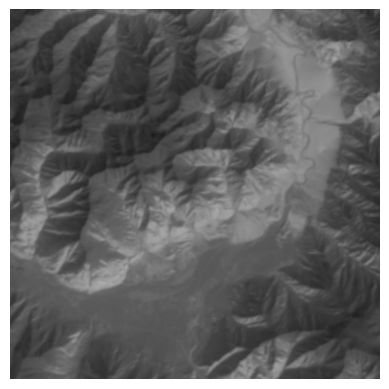

Image shape: (800, 800, 3)


In [5]:
image = Image.open("/kaggle/input/informed-images/trying_last/tir/crop_1.png")
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()
image_array = np.array(image)
# print(image_array)
# Print the shape of the image
print("Image shape:", image_array.shape)


Making dataset by merge all three types into one by downsampling (bicubic) the hr image (ground truth)

In [6]:
class InformedSatelliteDataset(Dataset):
    def __init__(self, triplets, transform=None, downscale_factor=2):
        self.triplets = triplets  # List of (normal_path, qb_path, tir_path)
        self.transform = transform
        self.downscale_factor = downscale_factor
    
    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        normal_path, qb_path, tir_path = self.triplets[idx]

        # Load images without conversion
        hr_normal = Image.open(normal_path)
        qb_image = Image.open(qb_path)
        tir_image = Image.open(tir_path)

        # Resize normal to create LR version
        lr_width, lr_height = hr_normal.width // self.downscale_factor, hr_normal.height // self.downscale_factor
        lr_normal = hr_normal.resize((lr_width, lr_height), resample=Image.BICUBIC)
        lr_normal = lr_normal.resize(hr_normal.size, resample=Image.BICUBIC)  # Simulate LR input (upsampled)

        # Apply transforms
        resizer1 = transforms.Resize((low_res,low_res))    # 64*64
        resizer2 = transforms.Resize((high_res,high_res))  # 256*256
        if self.transform:
            hr_normal = self.transform(hr_normal)
            hr_normal = resizer2(hr_normal)

            lr_normal = self.transform(lr_normal)
            lr_normal = resizer1(lr_normal)

            qb_image = self.transform(qb_image)
            qb_image = resizer1(qb_image)

            tir_image = self.transform(tir_image)
            tir_image = resizer1(tir_image)
            
        # Concatenate LR normal + QB + TIR (all are [3,H,W])
        informed_input = torch.cat([lr_normal, qb_image, tir_image], dim=0)  # Shape: [9, H, W]

        return informed_input, hr_normal  # Output: (input with aux info, target HR image)


check if the size of image is 800*800 and channel is 9  or not


In [7]:


# Directories
normal_dir = "/kaggle/input/informed-images/trying_last/normal"
qb_dir = "/kaggle/input/informed-images/trying_last/qb"
tir_dir = "/kaggle/input/informed-images/trying_last/tir"

# Collect filenames (suffixes)
normal_files = os.listdir(normal_dir)
qb_files = set(os.listdir(qb_dir))
tir_files = set(os.listdir(tir_dir))

# Only keep .png files
normal_files = [f for f in normal_files if f.endswith('.png')]

valid_triplets = []
invalid_triplets = []

for fname in normal_files:
    if fname in qb_files and fname in tir_files:
        # Load all three images
        try:
            normal_path = os.path.join(normal_dir, fname)
            qb_path = os.path.join(qb_dir, fname)
            tir_path = os.path.join(tir_dir, fname)

            normal_img = Image.open(normal_path)
            qb_img = Image.open(qb_path)
            tir_img = Image.open(tir_path)

            # Check size
            if normal_img.size == (800, 800) and qb_img.size == (800, 800) and tir_img.size == (800, 800):
                valid_triplets.append((normal_path, qb_path, tir_path))
            else:
                invalid_triplets.append(fname)

        except Exception as e:
            print(f"Error loading image {fname}: {e}")
            invalid_triplets.append(fname)
    else:
        invalid_triplets.append(fname)

print(f" Total valid triplets: {len(valid_triplets)}")
if invalid_triplets:
    print(" Invalid or mismatched triplets:")
    for f in invalid_triplets:
        print(f" - {f}")


 Total valid triplets: 1376


train test split of 90-10 with batch size of 4

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
import glob
from sklearn.model_selection import train_test_split

# Assuming you've already collected valid triplets in `valid_triplets`
# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    # transforms.Resize((100,100))
])

# Split into train/val
train_triplets, val_triplets = train_test_split(valid_triplets, test_size=0.1, random_state=42)

# Create datasets and dataloaders
train_dataset = InformedSatelliteDataset(train_triplets, transform=transform)
val_dataset = InformedSatelliteDataset(val_triplets, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)



Plots of resized and ground truth images

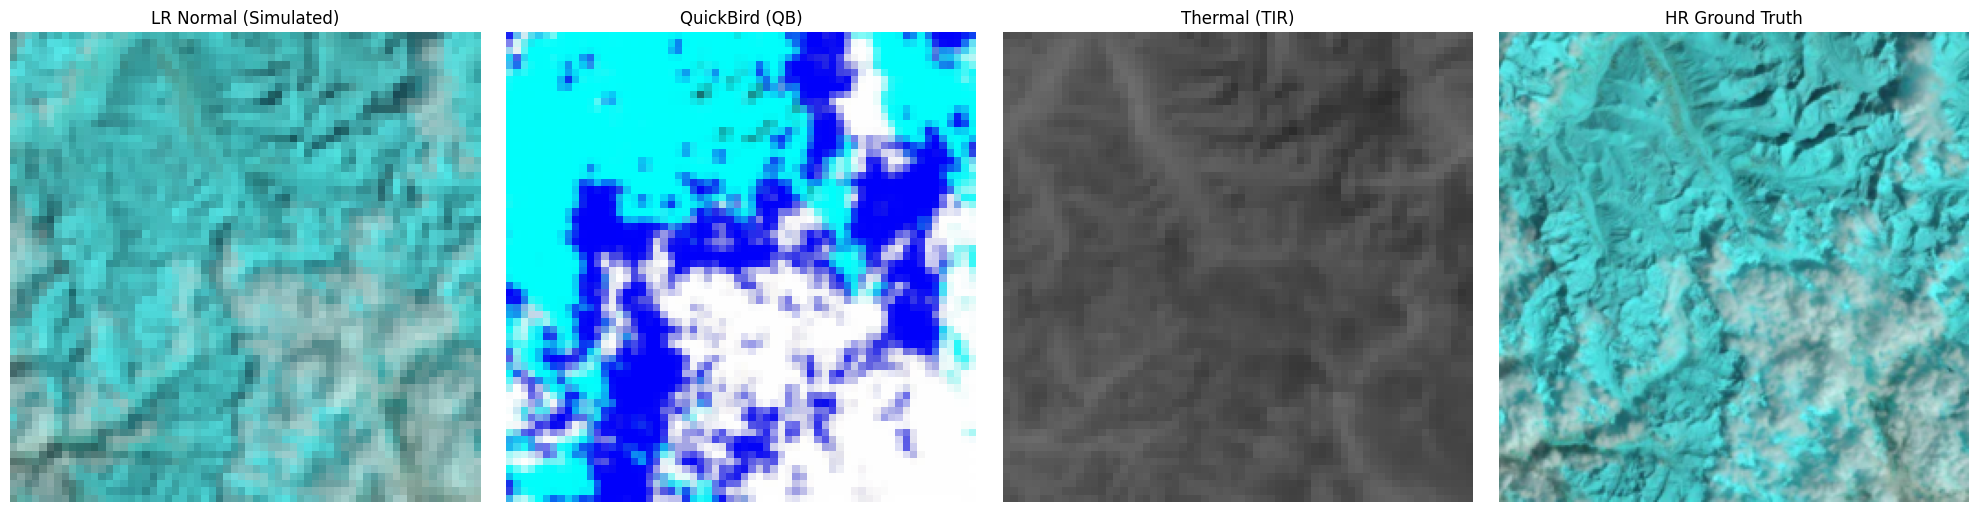

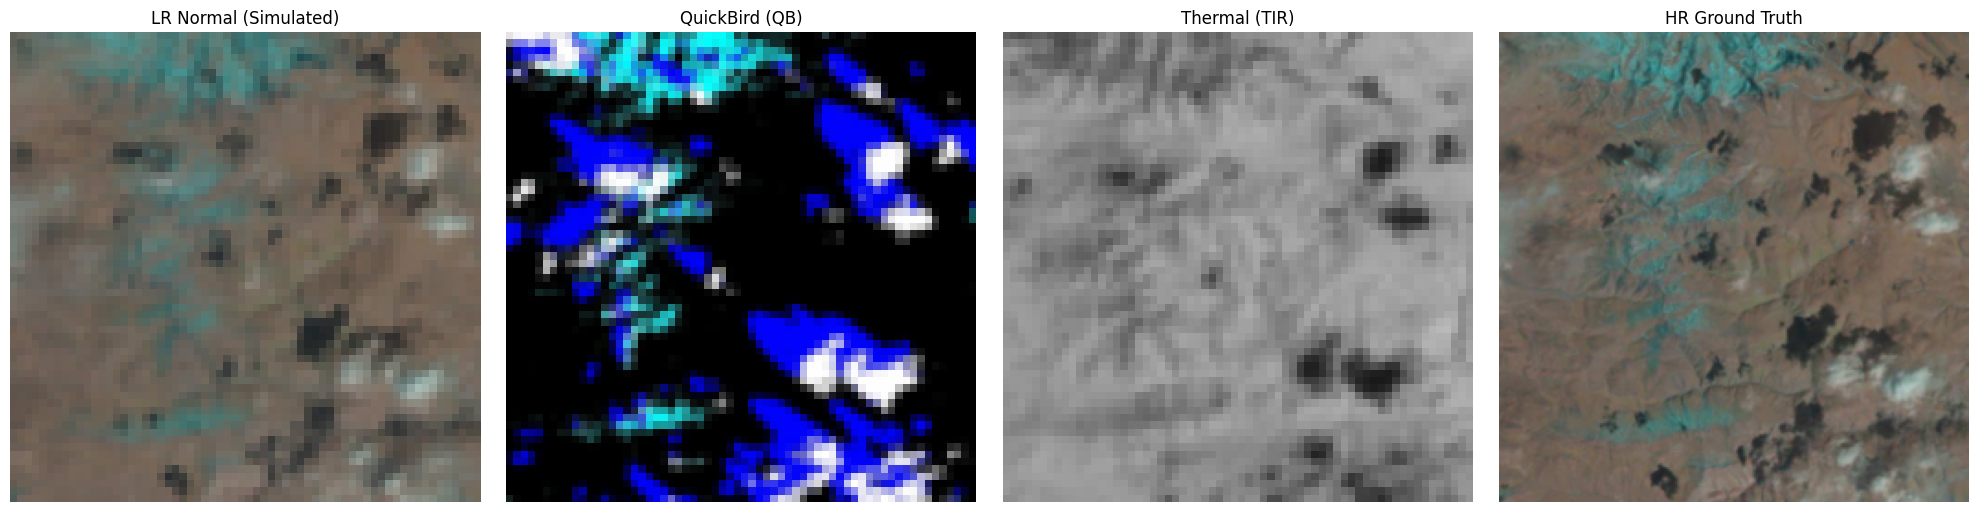

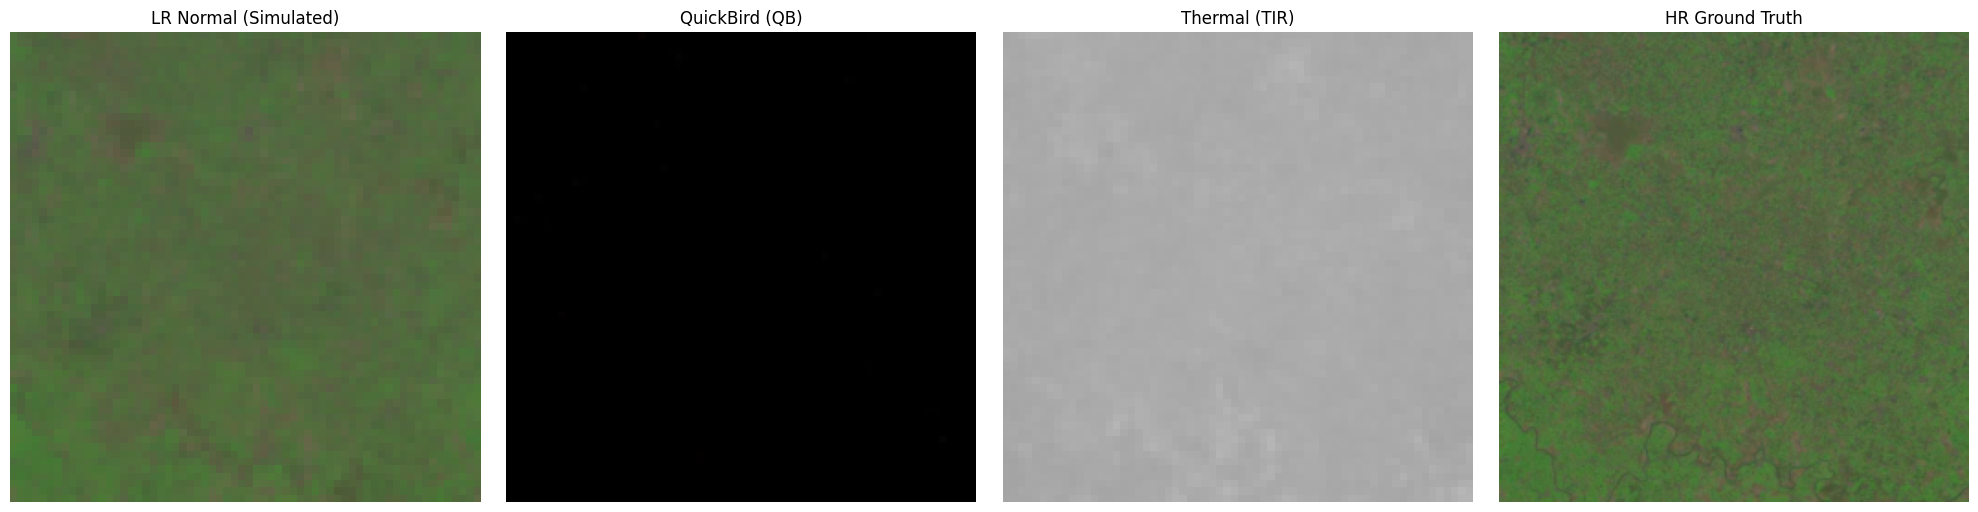

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def show_lr_hr_pairs(dataset, num_samples=2):
    for i in range(num_samples):
        informed_input, hr = dataset[i]
        # print(f"informed input has shape{informed_input.shape}")

        # Extract LR Normal (first 3 channels)
        lr = informed_input[:3]
        qb = informed_input[3:6]
        tir = informed_input[6:]

        # Convert to numpy and denormalize from [-1, 1] to [0, 1]
        def denorm(tensor):
            return ((tensor.permute(1, 2, 0).numpy() + 1) / 2).clip(0, 1)

        lr_np = denorm(lr)
        # print(f"lr_np has shape: {lr_np.shape}")
        
        qb_np = denorm(qb)
        # print(f"qb_np has shape: {qb_np.shape}")
        
        # tir_np = tir.squeeze(0).numpy()  # [1, H, W] -> [H, W]
        # tir_np = ((tir_np + 1) / 2).clip(0, 1)
        tir_np = denorm(tir)
        # print(f"tir_np has shape: {tir_np.shape}")

        hr_np = denorm(hr)
        # print(f"hr_np has shape: {hr_np.shape}")

        # Plot
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(lr_np)
        axs[0].set_title("LR Normal (Simulated)")
        axs[0].axis('off')

        axs[1].imshow(qb_np)
        axs[1].set_title("QuickBird (QB)")
        axs[1].axis('off')

        axs[2].imshow(tir_np, cmap='gray')
        axs[2].set_title("Thermal (TIR)")
        axs[2].axis('off')

        axs[3].imshow(hr_np)
        axs[3].set_title("HR Ground Truth")
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()

show_lr_hr_pairs(train_dataset, num_samples=3)


extracts patch-like features from an image using a convolutional layer and reshapes them into a sequence suitable for transformer input

In [10]:
import torch
import torch.nn as nn

class PatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=96, new_dim=32):
        super(PatchEmbed, self).__init__()
        # self.proj1 = nn.Conv2d(in_channels, new_dim, kernel_size=1)
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=3, padding = 1) # learnable patch extractor
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x: [B, C, H, W]
        # x = self.proj1(x)  # [B, embed_dim, H//p, W//p]
        x = self.proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, H*W, C]
        x = self.norm(x)
        # print(f"shape of patch {x.shape}")
        return x, (H, W)


adds learnable positional information to each patch embedding so the model can understand the order and location of patches

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, num_patches):
        super(PositionalEncoding, self).__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embed


using multi-head attention, helping the model fuse information from different input sources

In [12]:
class CrossModalityAttention(nn.Module):
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super(CrossModalityAttention, self).__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, lr_tokens, aux_tokens):
        attn_output, _ = self.cross_attn(query=lr_tokens, key=aux_tokens, value=aux_tokens)
        x = self.norm1(lr_tokens + self.dropout(attn_output))
        ff_out = self.ffn(x)
        return self.norm2(x + ff_out)


dense block where features grow through concatenation, with a residual connection to ensure gradient flow

In [13]:
# class DenseResidualBlock(nn.Module):
#     def __init__(self, in_channels, growth_rate=32, num_layers=3):
#         super(DenseResidualBlock, self).__init__()
#         self.layers = nn.ModuleList()
#         self.in_channels = in_channels
#         channels = in_channels
#         for _ in range(num_layers):
#             self.layers.append(nn.Conv2d(channels, growth_rate, kernel_size=3, padding=1))
#             channels += growth_rate  # growth in channels

#         self.conv_out = nn.Conv2d(channels, in_channels, kernel_size=1)  # compress back to in_channels

#     def forward(self, x):
#         features = [x]
#         for conv in self.layers:
#             out = F.leaky_relu(conv(torch.cat(features, dim=1)), negative_slope=0.2)
#             features.append(out)
#         return x + self.conv_out(torch.cat(features, dim=1))  # residual connection

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, growth_rate=32):
        super(DenseResidualBlock, self).__init__()
        mid_channels = in_channels + growth_rate

        # Downsampling path
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(growth_rate, mid_channels, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # Upsampling path
        self.conv3 = nn.Conv2d(mid_channels, growth_rate, kernel_size=3, padding=1)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.conv4 = nn.Conv2d(growth_rate, in_channels, kernel_size=3, padding=1)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        # Final residual compression
        self.conv_out = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        identity = x

        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = self.pool1(x)

        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = self.pool2(x)

        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        x = self.up1(x)

        x = F.leaky_relu(self.conv4(x), negative_slope=0.2)
        x = self.up2(x)

        # Match original size (may need cropping or padding if input was not divisible by 4)
        if x.shape[-2:] != identity.shape[-2:]:
            x = F.interpolate(x, size=identity.shape[-2:], mode='bilinear', align_corners=False)

        out = self.conv_out(x)
        return identity + out  # Residual connection


Combines transformer-guided features with local residual features, using a dense block architecture

In [15]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels1, in_channels2, out_channels, num_dense_blocks=3):
        super(BasicBlock, self).__init__()

        # Transformer-guided path (x1): 3 conv layers + hardtanh
        self.guidance = nn.Sequential(
            nn.Conv2d(in_channels1, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.Hardtanh()
        )

        # Local residual dense path (x2)
        # self.local_res = DenseResidualBlock(in_channels2)
        self.local_res = nn.Sequential(
            *[DenseResidualBlock(out_channels) for _ in range(num_dense_blocks)]
        )

        # Final fusion conv after concat
        self.fusion = nn.Conv2d(out_channels + in_channels2, out_channels, kernel_size=3, padding=1)

    def forward(self, x1, x2):
        """
        x1: transformer-guided input [B, in_channels1, H, W]
        x2: local path input [B, in_channels2, H, W]
        """
        g = self.guidance(x1)        # processed transformer path
        r = self.local_res(x2)       # processed local path

        x = g * r

        x += x2
        return x


extractor fuses features from multi-modal inputs using patch embedding and cross-modality attention, enabling richer and spatially-aware feature representations

In [16]:
class TransformerFeatureExtractor(nn.Module):
    def __init__(self, in_channels=3, embed_dim=96, num_heads=4):
        super(TransformerFeatureExtractor, self).__init__()
        self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(in_channels, embed_dim)

        num_patches = (low_res ) ** 2  # assuming input size is always x * x
        self.pos_embed = PositionalEncoding(embed_dim, num_patches)

        self.cross_attention = CrossModalityAttention(embed_dim, num_heads)

    def forward(self, x):
        # Split input into 3 parts: LR, QB, TIR
        lr, qb, tir = x[:, :3], x[:, 3:6], x[:, 6:]
        # print(f"lr shape is {lr.shape}")
        # Use patch embedding
        lr_tokens, _ = self.patch_embed(lr)
        qb_tokens, _ = self.patch_embed(qb)
        tir_tokens, _ = self.patch_embed(tir)

        # Apply positional encoding
        lr_tokens = self.pos_embed(lr_tokens)
        qb_tokens = self.pos_embed(qb_tokens)
        tir_tokens = self.pos_embed(tir_tokens)

        # Fuse QB + TIR
        aux_tokens = lr_tokens + qb_tokens + tir_tokens

        # Cross-modality attention
        x_out = self.cross_attention(lr_tokens, aux_tokens)    # key and values are combined of all types of images

        # Reshape back to feature map
        B, N, C = x_out.shape
        H = W = int(N ** 0.5)  # assuming square patch layout
        x_out = x_out.transpose(1, 2).reshape(B, C, H, W)
        return x_out


upsampling block increases spatial resolution while preserving key features and stabilizing learning using skip connections

In [17]:
class ResidualUpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)  # match channels

    def forward(self, x):
        residual = self.upsample(self.skip(x))
        x = self.upsample(x)
        x = self.block(x)
        return x + residual


generator fuses global transformer features and local convolutions, then upsamples the result to synthesize high-resolution images from multi-modal low-res inputs

In [18]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, embed_dim=96, num_heads=4):
        super(Generator, self).__init__()

        # Transformer feature extractor
        self.feature_extractor = TransformerFeatureExtractor(
            in_channels=in_channels,
            embed_dim=embed_dim,
            num_heads=num_heads
        )

        # 3x3 Conv on LR input only (3 channels)
        self.lr_conv = nn.Conv2d(3, embed_dim, kernel_size=3, padding=1)

        # BasicBlocks: each takes transformer x + previous output
        self.bb1 = BasicBlock(in_channels1=embed_dim, in_channels2=embed_dim, out_channels=embed_dim)
        self.bb2 = BasicBlock(in_channels1=embed_dim, in_channels2=embed_dim, out_channels=embed_dim)
        self.bb3 = BasicBlock(in_channels1=embed_dim, in_channels2=embed_dim, out_channels=embed_dim)

        # Merge path output
        self.merge_conv = nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1)

        # Residual Upsampling
        self.residual_upsample = nn.Sequential(
            ResidualUpsampleBlock(embed_dim, embed_dim * 2),
            ResidualUpsampleBlock(embed_dim * 2, embed_dim * 4),
            nn.Conv2d(embed_dim * 4, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, full_input):
        """
        full_input: 9-channel image [LR + QB + TIR], shape: [B, 9, H, W]
        """
        # Split LR (first 3 channels) and full multi-modal input
        lr = full_input[:, :3, :, :]
        
        # Transformer path
        feature_extract = self.feature_extractor(full_input)  # [B, embed_dim, H, W]
        x = F.hardtanh(feature_extract)

        # Local Conv path
        lr_feat = self.lr_conv(lr)

        # Basic blocks guided by transformer output
        out1 = self.bb1(x, lr_feat)
        out2 = self.bb2(x, out1)
        out3 = self.bb3(x, out2)

        # Merge block output
        merged = self.merge_conv(out3)

        # Final upsampling
        out = self.residual_upsample(merged)          # final output of 256*256
        return out, feature_extract

discriminator network evaluates whether an image is real or generated, providing adversarial feedback to improve the generator's realism

In [19]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2,2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (high_res//8) * (high_res//8), 512),  # assuming input image is x*x -> first dimension = 4 * x * x
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


**Adversarial Loss** pushes the generator to create images that can fool the discriminator, encouraging realism.  
**Content Loss** ensures the generated images remain structurally and contextually close to the ground truth using pixel-wise L1 distance.


In [20]:
# Binary Cross-Entropy Loss for GAN
def adversarial_loss(output, target, is_generator=True):
    if is_generator:
        # Generator tries to fool the discriminator
        return nn.BCEWithLogitsLoss()(output, target)
    else:
        # Discriminator tries to classify real vs fake
        return nn.BCEWithLogitsLoss()(output, target)

# Content Loss (e.g., L1 loss)
def content_loss(output, target):
    return nn.L1Loss()(output, target)

def edge_loss(pred, target):
    sobel = SobelFilter().to(pred.device)
    pred_edges = sobel(pred)
    target_edges = sobel(target)
    return F.l1_loss(pred_edges, target_edges)



In [22]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Generator Loss')
    plt.plot(val_losses, label='Val Generator Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Generator Loss")
    plt.grid(True)
    plt.show()


def plot_metrics(psnr_scores, ssim_scores):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(psnr_scores, label='PSNR')
    plt.xlabel("Epoch")
    plt.ylabel("PSNR")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(ssim_scores, label='SSIM')
    plt.xlabel("Epoch")
    plt.ylabel("SSIM")
    plt.grid(True)
    plt.legend()
    plt.show()

**Discriminator Loss** combines real and fake classification losses to improve its ability to distinguish generated images.  
**Generator Loss** blends adversarial loss (realism) with L1 content loss (fidelity) to generate high-quality images.  
**Validation Loss** (L1) evaluates structural similarity, while **PSNR** and **SSIM** assess perceptual quality during validation.


In [24]:
from tqdm import tqdm
import time
import numpy as np
import torch
import skimage.metrics

def train_gan(generator, discriminator, train_loader, val_loader, optimizer_g, optimizer_d,
              num_epochs=10, device='cuda', patience=5):
    best_val_loss = float('inf')
    early_stop_counter = 0

    train_g_losses = []
    train_d_losses = []
    val_g_losses = []
    psnr_scores = []
    ssim_scores = []
    best_psnr =0

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        start_epoch = time.time()

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        pbar = tqdm(train_loader, total=len(train_loader), leave=False, desc="Training")

        for i, (lr_qb_tir, hr) in enumerate(pbar):
            iter_start = time.time()
            lr_qb_tir, hr = lr_qb_tir.to(device), hr.to(device)

            # ----------------------------------------------- Train Discriminator ----------------------------------------------------------------------
            optimizer_d.zero_grad()
            real_pred = discriminator(hr)
            real_loss = adversarial_loss(real_pred, torch.ones_like(real_pred), is_generator=False)

            fake_hr, _= generator(lr_qb_tir)
            fake_pred = discriminator(fake_hr.detach())
            fake_loss = adversarial_loss(fake_pred, torch.zeros_like(fake_pred), is_generator=False)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_d.step()

            # ------------------------------------------------- Train Generator ------------------------------------------------------------------------
            optimizer_g.zero_grad()
            fake_pred = discriminator(fake_hr)
            g_loss = adversarial_loss(fake_pred, torch.ones_like(fake_pred), is_generator=True)
            l1 = content_loss(fake_hr, hr)
            #e_loss = edge_loss(fake_hr, hr)
            total_g_loss = g_loss +  l1 #+ 0.1 * e_loss
            total_l1_g_loss = l1
            total_g_loss.backward()
            optimizer_g.step()

            # Update losses
            epoch_g_loss += total_l1_g_loss.item()
            epoch_d_loss += d_loss.item()

            # Update tqdm bar
            elapsed = time.time() - iter_start
            it_per_sec = 1.0 / elapsed
            eta = (len(train_loader) - i - 1) * elapsed

            pbar.set_postfix({
                "it/s": f"{it_per_sec:.2f}",
                "ETA": f"{eta:.1f}s",
                "D Loss": f"{d_loss.item():.4f}",
                "G L1 Loss": f"{total_l1_g_loss.item():.4f}"
            })

        # Logging epoch losses
        avg_g_loss = epoch_g_loss / len(train_loader)
        avg_d_loss = epoch_d_loss / len(train_loader)
        train_g_losses.append(avg_g_loss)
        train_d_losses.append(avg_d_loss)

        # ----- Validation -----
        generator.eval()
        val_loss = 0.0
        epoch_psnr = []
        epoch_ssim = []

        with torch.no_grad():
            for lr_qb_tir, hr in val_loader:
                lr_qb_tir, hr = lr_qb_tir.to(device), hr.to(device)
                fake_hr, _ = generator(lr_qb_tir)

                l1_val = content_loss(fake_hr, hr)
                val_loss += l1_val.item()

                for i in range(fake_hr.size(0)):
                    pred = fake_hr[i].cpu().numpy().transpose(1, 2, 0)
                    gt = hr[i].cpu().numpy().transpose(1, 2, 0)
    
                    # Ensure pixel values are in [0, 1]
                    pred_ssim = np.clip(pred, 0, 1)
                    gt_ssim = np.clip(gt, 0, 1)
    
                    psnr = peak_signal_noise_ratio(pred, gt)
                    ssim = structural_similarity(gt_ssim, pred_ssim, data_range=1, channel_axis=-1, win_size=7)
    
                    # psnr_list.append(psnr)
                    # ssim_list.append(ssim)
                
                # hr_np = hr.cpu().numpy().transpose(0, 2, 3, 1)
                # fake_np = fake_hr.cpu().numpy().transpose(0, 2, 3, 1)
                
                # for h, f in zip(hr_np, fake_np):
                #     psnr = skimage.metrics.peak_signal_noise_ratio(h, f, data_range=1.0)
                #     # ssim = skimage.metrics.structural_similarity(h, f, multichannel=True)
                #     ssim = skimage.metrics.structural_similarity(h, f, data_range=1.0, channel_axis=-1, win_size=7)
                    epoch_psnr.append(psnr)
                    epoch_ssim.append(ssim)

        avg_val_loss = val_loss / len(val_loader)
        val_g_losses.append(avg_val_loss)
        psnr_scores.append(np.mean(epoch_psnr))
        ssim_scores.append(np.mean(epoch_ssim))

        print(f"Epoch [{epoch+1}/{num_epochs}]  | "
              f"Train G: {avg_g_loss:.4f}, D: {avg_d_loss:.4f} | "
              f"Val G L1 loss: {avg_val_loss:.4f} | PSNR: {psnr_scores[-1]:.2f}, SSIM: {ssim_scores[-1]:.4f}")

        # Early stopping
        if best_psnr < epoch_psnr[-1]:
            best_psnr = epoch_psnr[-1]
            early_stop_counter = 0
            torch.save(generator.state_dict(), 'best_generator.pth')
            torch.save(discriminator.state_dict(), 'best_discriminator.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(" Early stopping triggered!")
                break

    # Plot Loss and Metrics
    plot_losses(train_g_losses, val_g_losses)
    plot_metrics(psnr_scores, ssim_scores)


In [25]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Set the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = [0.485, 0.456, 0.406]  # Example values for ImageNet normalization
std = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    """
    Denormalize the image tensor based on mean and std used during normalization.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_predictions(model, dataloader, device, num_images=10):
    """
    Visualizes the Low-Resolution (LR) images, Super-Resolution (SR) outputs, and High-Resolution (HR) ground truths.
    """
    model.eval()  # Set the model to evaluation mode
    fig, axes = plt.subplots(num_images, 4, figsize=(12, 4 * num_images))  # Create subplots
    

    count = 0
    with torch.no_grad():  # No gradient calculation needed for inference
        indices = random.sample(range(len(val_dataset)), num_images)

        for count, idx in enumerate(indices):
        # for data in dataloader:
            # LR, QB, and TIR are already combined into one input tensor
            lr_qb_tir, hr_imgs = dataloader.dataset[idx]
            lr_qb_tir = lr_qb_tir.unsqueeze(0).to(device)
            hr_imgs = hr_imgs.unsqueeze(0).to(device)
             # HR images
            # print(lr_qb_tir.shape)
            
            # Pass the inputs to the model
            # sr_imgs, featureMap = model(lr_qb_tir)
            sr_imgs, featureMap = model(lr_qb_tir)

            for j in range(lr_qb_tir.shape[0]):
                if count >= num_images:
                    break

                # Denormalize the images (assumes images were normalized with the same mean/std)
                lr_qb_tir_np = denormalize(lr_qb_tir[j].cpu(), mean, std)
                sr_np = denormalize(sr_imgs[j].cpu(), mean, std)
                hr_np = denormalize(hr_imgs[j].cpu(), mean, std)

                # After converting tensor to PIL image (sr_np in your case):
                # enhancer = ImageEnhance.Sharpness(sr_np)
                # sr_sharp = enhancer.enhance(2.0)  # 1.0 = original, >1 = sharper, <1 = blurry
                sr_pil = to_pil_image(sr_np.clamp(0, 1))  # Make sure it's in range [0, 1]
                enhancer = ImageEnhance.Sharpness(sr_pil)
                sr_sharp = enhancer.enhance(2.0)
                # Use sr_sharp instead of sr_np for plotting or saving
                # axes[count][1].imshow(sr_sharp)
                # axes[count][1].set_title("Super-Res Output (Sharpened)")

                # Convert tensors to PIL images for visualization (only first 3 channels for visualization)
                lr_qb_tir_np = TF.to_pil_image(lr_qb_tir_np[:3].clamp(0, 1))  # Visualize only the first 3 channels (RGB)
                # sr_np = TF.to_pil_image(sr_sharp.clamp(0, 1))
                hr_np = TF.to_pil_image(hr_np.clamp(0, 1))
                fm_np = TF.to_pil_image(featureMap[j].cpu().clamp(0, 1).mean(dim=0))

                # Plot the images: LR, SR, HR
                axes[count][0].imshow(lr_qb_tir_np)
                axes[count][0].set_title("Low-Res Input")
                axes[count][1].imshow(sr_sharp)
                axes[count][1].set_title("Super-Res Output (Sharpened)")
                axes[count][2].imshow(hr_np)
                axes[count][2].set_title("High-Res Ground Truth")
                axes[count][3].imshow(fm_np)
                axes[count][3].set_title("Transformer mean feature map")


                # Turn off axis for neatness
                for ax in axes[count]:
                    ax.axis("off")

                count += 1

            if count >= num_images:
                break

    plt.tight_layout()
    plt.show()


In [26]:
# Training Call
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(in_channels=3, embed_dim=96, num_heads=4).to(device)
discriminator = Discriminator(in_channels=3).to(device)

In [ ]:
lr = 1e-4  # Adjust learning rate as necessary
beta1 = 0.9
beta2 = 0.999

optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

train_gan(generator, discriminator, train_loader, val_loader, optimizer_g, optimizer_d, num_epochs=10, device=device, patience=3)




Epoch 1/10


Training:  65%|██████▌   | 202/310 [04:52<02:39,  1.47s/it, it/s=1.01, ETA=107.3s, D Loss=0.6931, G L1 Loss=0.0551]

In [ ]:
# Load best model for evaluation
generator.load_state_dict(torch.load("/kaggle/working/best_generator.pth"))

# Visualize results
visualize_predictions(generator, val_loader, device=device)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
import torch

def evaluate_sr_model(model, dataloader, device):
    model.eval()
    psnr_list = []
    ssim_list = []

    with torch.no_grad():
        for batch in dataloader:
            # print(batch[0].shape)
            lr, hr = batch
            lr = lr.to(device)    # Shape: (B, 9, 64, 64)
            hr = hr.to(device)    # Shape: (B, 3, 256, 256)

            sr, _= model(lr)                 # Expected: (B, 3, 256, 256)

            for i in range(sr.size(0)):
                pred = sr[i].cpu().numpy().transpose(1, 2, 0)
                gt = hr[i].cpu().numpy().transpose(1, 2, 0)

                # Ensure pixel values are in [0, 1]
                pred_ssim = np.clip(pred, 0, 1)
                gt_ssim = np.clip(gt, 0, 1)

                psnr = peak_signal_noise_ratio(pred, gt)
                ssim = structural_similarity(gt_ssim, pred_ssim, data_range=1, channel_axis=-1, win_size=7)

                psnr_list.append(psnr)
                ssim_list.append(ssim)

    avg_psnr = np.mean(psnr_list)
    avg_ssim = np.mean(ssim_list)

    return avg_psnr, avg_ssim

# Evaluate
psnr,ssim = evaluate_sr_model(generator, val_loader, device)
print(f"Generator Super-Resolution → PSNR: {psnr:.2f}, SSIM : {ssim:.2f}")

In [ ]:
generator = Generator(in_channels=3, embed_dim=96, num_heads=4).to(device)
generator.load_state_dict(torch.load("/kaggle/working/best_generator.pth"))

Run the model on the non-satellite images

In [ ]:
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

# Load your original image
original_img = Image.open("/kaggle/input/human-image/Himmat.jpg").convert("RGB")

# Resize original image to 256x256 for fair visual comparison
original_resized_256 = original_img.resize((256, 256), Image.BICUBIC)

# Resize to 64x64 for input
resized_input_64 = original_img.resize((64, 64), Image.BICUBIC)
input_tensor = TF.to_tensor(resized_input_64).unsqueeze(0).to(device)

# Repeat 3 channels → 9 channels (3 times)
input_tensor = input_tensor.repeat(1, 3, 1, 1)

# Run the generator
generator.eval()
with torch.no_grad():
    sr_output, feature_map = generator(input_tensor)

# Prepare outputs
sr_img = sr_output[0].cpu().clamp(0, 1)
feature_map_img = feature_map[0].cpu().clamp(0, 1).mean(dim=0)  # (64, 64)

# Sharpen the SR image a bit
sr_pil = TF.to_pil_image(sr_img)
enhancer = ImageEnhance.Sharpness(sr_pil)
sr_sharp = enhancer.enhance(2.0)

# Plotting all 4 images
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

axes[0].imshow(original_resized_256)
axes[0].set_title("Original Image Resized (256×256)")

axes[1].imshow(resized_input_64)
axes[1].set_title("Resized Input (64×64)")

axes[2].imshow(sr_sharp)
axes[2].set_title("Super-Resolved Output (256×256)")

axes[3].imshow(feature_map_img, cmap="viridis")
axes[3].set_title("Feature Map Mean (64×64)")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

# Load your original image
original_img = Image.open("/kaggle/input/group-human-image/WhatsApp Image 2025-04-18 at 12.22.57_e9eaacef.jpg").convert("RGB")

# Resize original image to 256x256 for fair visual comparison
original_resized_256 = original_img.resize((256, 256), Image.BICUBIC)

# Resize to 64x64 for input
resized_input_64 = original_img.resize((64, 64), Image.BICUBIC)
input_tensor = TF.to_tensor(resized_input_64).unsqueeze(0).to(device)

# Repeat 3 channels → 9 channels (3 times)
input_tensor = input_tensor.repeat(1, 3, 1, 1)

# Run the generator
generator.eval()
with torch.no_grad():
    sr_output, feature_map = generator(input_tensor)

# Prepare outputs
sr_img = sr_output[0].cpu().clamp(0, 1)
feature_map_img = feature_map[0].cpu().clamp(0, 1).mean(dim=0)  # (64, 64)

# Sharpen the SR image a bit
sr_pil = TF.to_pil_image(sr_img)
enhancer = ImageEnhance.Sharpness(sr_pil)
sr_sharp = enhancer.enhance(2.0)

# Plotting all 4 images
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

axes[0].imshow(original_resized_256)
axes[0].set_title("Original Image Resized (256×256)")

axes[1].imshow(resized_input_64)
axes[1].set_title("Resized Input (64×64)")

axes[2].imshow(sr_sharp)
axes[2].set_title("Super-Resolved Output (256×256)")

axes[3].imshow(feature_map_img, cmap="viridis")
axes[3].set_title("Feature Map Mean (64×64)")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()
